In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


class LadderNet(nn.Module):
    def __init__(self, input_shape, num_classes, rc_rate = 0.25):
        super(LadderNet, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.rc_rate = rc_rate

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Decoder layers
        self.deconv4 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(32)
        self.deconv1 = nn.ConvTranspose2d(32, 1, kernel_size=4, padding=1)

        # Classification layer
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x_labeled, x_unlabeled):
        if (x_labeled is not None):

            # Labeled input
            h = F.relu(self.bn1(self.conv1(x_labeled)))
            h = F.max_pool2d(h, 2, 2)
            out1 = h
            h = F.relu(self.bn2(self.conv2(h)))
            h = F.max_pool2d(h, 2, 2)
            out2 = h
            h = F.relu(self.bn3(self.conv3(h)))
            h = F.max_pool2d(h, 2, 2)
            out3 = h
            encoder_output = F.relu(self.bn4(self.conv4(h)))

        else:

            # Unlabeled input
            u = F.relu(self.bn1(self.conv1(x_unlabeled)))
            u = F.max_pool2d(u, 2, 2)
            out1 = u
            u = F.relu(self.bn2(self.conv2(u)))
            u = F.max_pool2d(u, 2, 2)
            out2 = u
            u = F.relu(self.bn3(self.conv3(u)))
            u = F.max_pool2d(u, 2, 2)
            out3 = u
            encoder_output = F.relu(self.bn4(self.conv4(u)))

        encoder_output = F.avg_pool2d(encoder_output, encoder_output.size()[2:])
        decoder_input = encoder_output
        encoder_output = encoder_output.view(-1, 256)

        # Add noise to the hidden representations
        noise = torch.randn_like(encoder_output)
        distorted_encoder_output = encoder_output + noise

        # Decoder
        u = F.relu(self.bn5(self.deconv4(distorted_encoder_output.view(-1, 256, 1, 1))))
        u = F.interpolate(u, scale_factor=3, mode='nearest')
        dout3 = u
        u = F.relu(self.bn6(self.deconv3(u)))
        u = F.interpolate(u, size=(7, 7), mode='nearest')
        dout2 = u
        u = F.relu(self.bn7(self.deconv2(u)))
        u = F.interpolate(u, size=(14, 14), mode='nearest')
        dout1 = u
        u = F.interpolate(self.deconv1(u), size=(28, 28), mode='nearest')
        x_reconstructed = torch.sigmoid(u)

        # Classification
        output = self.fc(encoder_output) if x_labeled is not None else None

        return output, x_reconstructed, out1, dout1, out2, dout2, out3, dout3

    def labeled_loss(self, output_labeled, target_labeled):
        criterion = nn.CrossEntropyLoss()
        return criterion(output_labeled, target_labeled)

    def reconstruction_loss(self, x_reconstructed, x_unlabeled, out1, dout1, out2, dout2, out3, dout3):
        mse_loss = nn.MSELoss()
        mse = mse_loss(x_reconstructed, x_unlabeled) + self.rc_rate * (
                mse_loss(out1, dout1) + mse_loss(out2, dout2) + mse_loss(out3, dout3))

        return mse

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 26421880/26421880 [00:04<00:00, 6313660.85it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 106497.37it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1986592.93it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15434079.34it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
# Divide the training set into labeled and unlabeled sets
n_labeled = int(0.05 * len(train_set))
n_unlabeled = len(train_set) - n_labeled
train_labeled_set, train_unlabeled_set = torch.utils.data.random_split(train_set, [n_labeled, n_unlabeled])

# Create data loaders for the labeled and unlabeled sets
batch_size = 128

from torch.utils.data import Dataset


class SemisupervisedDataset(Dataset):
    def __init__(self, labeled_dataset, unlabeled_dataset):
        self.labeled_dataset = labeled_dataset
        self.unlabeled_dataset = unlabeled_dataset
        self.unlabeled_size = len(unlabeled_dataset)
        self.labeled_size = len(labeled_dataset)
        print("Dataset created")

    def __len__(self):
        return self.unlabeled_size

    def __getitem__(self, index):
        labeled_data, labeled_target = self.labeled_dataset[index % self.labeled_size]
        unlabeled_data, _ = self.unlabeled_dataset[index]

        return labeled_data, labeled_target, unlabeled_data


dataset = SemisupervisedDataset(train_labeled_set, train_unlabeled_set)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

simple_labeled_dataloader = torch.utils.data.DataLoader(train_labeled_set, batch_size=batch_size, shuffle=True, pin_memory=True)
simple_labeled_test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Dataset created


device(type='cuda')

In [4]:
if torch.cuda.is_available():
    print('CUDA is available!')
else:
    print('CUDA is not available.')

CUDA is available!


In [5]:
from sklearn.metrics import classification_report


def plot_history(loss, accuracy, loss_dictionary, accuracy_dictionary, name):
    # create the accuracy plot
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
    plt.plot(accuracy)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # create the loss plot
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
    plt.plot(loss)
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # display the plots
    plt.tight_layout()  # to prevent overlapping of labels
    plt.show()

    loss_dictionary[name] = loss.copy()
    accuracy_dictionary[name] = accuracy.copy()


def evaluate_model(model, test_loader):
    preds = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output, _, _, _, _, _, _, _ = model(data, None)
            preds.extend(output.argmax(dim=1, keepdim=True).flatten().cpu().numpy())
            targets.extend(target.cpu().numpy())
    print(classification_report(targets, preds))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
from tqdm import tqdm
from torch import optim

# Define the model
model = LadderNet(input_shape=(1, 28, 28), num_classes=10)

# Move the model to the device
model.to(device)

# Define the loss functions
labeled_loss_fn = model.labeled_loss
reconstruction_loss_fn = model.reconstruction_loss

num_epochs = 10

# Define the optimizer
optimizer = optim.Adam(model.parameters())

accuracy_plot = []
loss_plot = []
accuracy_plots = {}
loss_plots = {}

# Train the model
for epoch in range(num_epochs):
    model.train()
    for data_labeled, target_labeled, data_unlabeled in tqdm(dataloader):
        # Train the model on the labeled data
        data_labeled = data_labeled.to(device)
        target_labeled = target_labeled.to(device)
        data_unlabeled = data_unlabeled.to(device)

        optimizer.zero_grad()
        output, x_reconstructed, out1, dout1, out2, dout2, out3, dout3 = model(data_labeled, None)
        loss_labeled = labeled_loss_fn(output, target_labeled) + reconstruction_loss_fn(data_labeled, x_reconstructed,
                                                                                        out1, dout1, out2, dout2, out3,
                                                                                        dout3)
        loss_labeled.backward()
        optimizer.step()

        # Train the model on the unlabeled data
        _, x_reconstructed, out1, dout1, out2, dout2, out3, dout3 = model(None, data_unlabeled)
        x_reconstructed = x_reconstructed.view(-1, 784)
        data_unlabeled = data_unlabeled.view(-1, 784)
        loss_unlabeled = reconstruction_loss_fn(data_unlabeled, x_reconstructed, out1, dout1, out2, dout2, out3, dout3)
        loss_unlabeled.backward()
        optimizer.step()

    # Test the model
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output, _, _, _, _, _, _, _ = model(data, None)
            test_loss += labeled_loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    loss_plot.append(test_loss)
    accuracy_plot.append(accuracy)
    print('Epoch: {} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch, test_loss, correct,
                                                                                       len(test_loader.dataset),
                                                                                       accuracy))

100%|██████████| 446/446 [00:30<00:00, 14.85it/s]


Epoch: 0 Test set: Average loss: 0.0040, Accuracy: 8491/10000 (85%)


100%|██████████| 446/446 [00:25<00:00, 17.23it/s]


Epoch: 1 Test set: Average loss: 0.0065, Accuracy: 8281/10000 (83%)


100%|██████████| 446/446 [00:25<00:00, 17.74it/s]


Epoch: 2 Test set: Average loss: 0.0057, Accuracy: 8517/10000 (85%)


100%|██████████| 446/446 [00:25<00:00, 17.61it/s]


Epoch: 3 Test set: Average loss: 0.0058, Accuracy: 8562/10000 (86%)


100%|██████████| 446/446 [00:25<00:00, 17.46it/s]


Epoch: 4 Test set: Average loss: 0.0059, Accuracy: 8558/10000 (86%)


100%|██████████| 446/446 [00:25<00:00, 17.32it/s]


Epoch: 5 Test set: Average loss: 0.0062, Accuracy: 8510/10000 (85%)


100%|██████████| 446/446 [00:25<00:00, 17.25it/s]


Epoch: 6 Test set: Average loss: 0.0067, Accuracy: 8560/10000 (86%)


100%|██████████| 446/446 [00:25<00:00, 17.36it/s]


Epoch: 7 Test set: Average loss: 0.0063, Accuracy: 8567/10000 (86%)


100%|██████████| 446/446 [00:25<00:00, 17.32it/s]


Epoch: 8 Test set: Average loss: 0.0101, Accuracy: 8094/10000 (81%)


100%|██████████| 446/446 [00:25<00:00, 17.19it/s]


Epoch: 9 Test set: Average loss: 0.0071, Accuracy: 8560/10000 (86%)


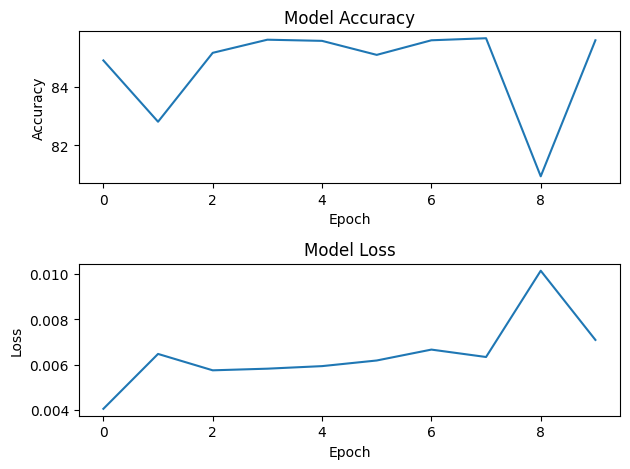

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.75      0.77      1000
           3       0.87      0.85      0.86      1000
           4       0.76      0.79      0.78      1000
           5       0.97      0.94      0.95      1000
           6       0.59      0.67      0.63      1000
           7       0.92      0.95      0.93      1000
           8       0.95      0.96      0.96      1000
           9       0.95      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [7]:
plot_history(loss_plot, accuracy_plot, loss_plots, accuracy_plots, 'ladder with 0.25 reconstruction cost')
evaluate_model(model, test_loader)

## Звичайна модель

In [8]:
class SimpleModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SimpleModel, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Classification layer
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x_labeled):
        # Labeled input
        h = F.relu(self.bn1(self.conv1(x_labeled)))
        h = F.max_pool2d(h, 2, 2)
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.max_pool2d(h, 2, 2)
        h = F.relu(self.bn3(self.conv3(h)))
        h = F.max_pool2d(h, 2, 2)
        encoder_output = F.relu(self.bn4(self.conv4(h)))
        encoder_output = F.avg_pool2d(encoder_output, encoder_output.size()[2:])
        encoder_output = encoder_output.view(-1, 256)

        # Classification

        output = self.fc(encoder_output)

        return output


    def labeled_loss(self, output_labeled, target_labeled):
        criterion = nn.CrossEntropyLoss()
        return criterion(output_labeled, target_labeled)

In [9]:
from tqdm import tqdm
from torch import optim

# Define the model
model = SimpleModel(input_shape=(1, 28, 28), num_classes=10)

# Move the model to the device
model.to(device)

# Define the loss functions
labeled_loss_fn = model.labeled_loss

num_epochs = 10

# Define the optimizer
optimizer = optim.Adam(model.parameters())

accuracy_plot = []
loss_plot = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    for data_labeled, target_labeled in tqdm(simple_labeled_dataloader):
        # Train the model on the labeled data
        data_labeled = data_labeled.to(device)
        target_labeled = target_labeled.to(device)

        optimizer.zero_grad()
        output = model(data_labeled)
        loss_labeled = labeled_loss_fn(output, target_labeled)
        loss_labeled.backward()
        optimizer.step()

    # Test the model
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in simple_labeled_test_dataloader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += labeled_loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(simple_labeled_test_dataloader.dataset)
    accuracy = 100. * correct / len(simple_labeled_test_dataloader.dataset)
    loss_plot.append(test_loss)
    accuracy_plot.append(accuracy)
    print('Epoch: {} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch, test_loss, correct,
                                                                                       len(test_loader.dataset),
                                                                                       accuracy))

100%|██████████| 24/24 [00:00<00:00, 39.30it/s]


Epoch: 0 Test set: Average loss: 0.0066, Accuracy: 7500/10000 (75%)


100%|██████████| 24/24 [00:00<00:00, 38.22it/s]


Epoch: 1 Test set: Average loss: 0.0049, Accuracy: 7937/10000 (79%)


100%|██████████| 24/24 [00:00<00:00, 40.84it/s]


Epoch: 2 Test set: Average loss: 0.0066, Accuracy: 7207/10000 (72%)


100%|██████████| 24/24 [00:00<00:00, 40.37it/s]


Epoch: 3 Test set: Average loss: 0.0041, Accuracy: 8176/10000 (82%)


100%|██████████| 24/24 [00:00<00:00, 39.87it/s]


Epoch: 4 Test set: Average loss: 0.0066, Accuracy: 6930/10000 (69%)


100%|██████████| 24/24 [00:00<00:00, 37.19it/s]


Epoch: 5 Test set: Average loss: 0.0053, Accuracy: 7619/10000 (76%)


100%|██████████| 24/24 [00:00<00:00, 41.12it/s]


Epoch: 6 Test set: Average loss: 0.0036, Accuracy: 8447/10000 (84%)


100%|██████████| 24/24 [00:00<00:00, 39.92it/s]


Epoch: 7 Test set: Average loss: 0.0037, Accuracy: 8422/10000 (84%)


100%|██████████| 24/24 [00:00<00:00, 38.60it/s]


Epoch: 8 Test set: Average loss: 0.0079, Accuracy: 7111/10000 (71%)


100%|██████████| 24/24 [00:00<00:00, 38.71it/s]


Epoch: 9 Test set: Average loss: 0.0058, Accuracy: 7885/10000 (79%)


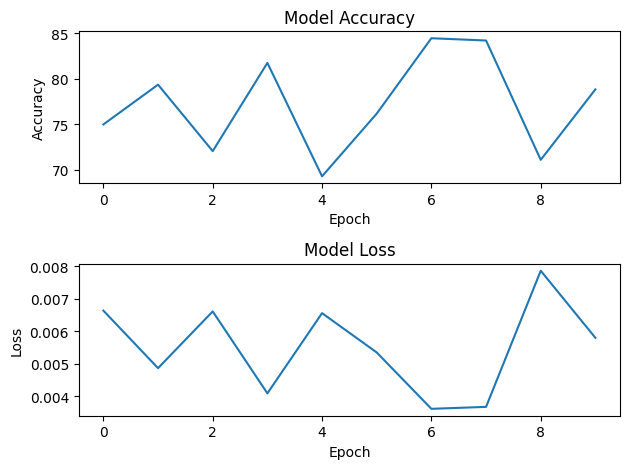

              precision    recall  f1-score   support

           0       0.95      0.34      0.50      1000
           1       1.00      0.84      0.91      1000
           2       0.77      0.68      0.72      1000
           3       0.73      0.89      0.80      1000
           4       0.57      0.92      0.71      1000
           5       0.99      0.86      0.92      1000
           6       0.50      0.61      0.55      1000
           7       0.92      0.87      0.89      1000
           8       0.99      0.89      0.94      1000
           9       0.84      0.98      0.90      1000

    accuracy                           0.79     10000
   macro avg       0.83      0.79      0.79     10000
weighted avg       0.83      0.79      0.79     10000



In [10]:
def evaluate_simple_model(model, test_loader):
    preds = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            preds.extend(output.argmax(dim=1, keepdim=True).flatten().cpu().numpy())
            targets.extend(target.cpu().numpy())
    print(classification_report(targets, preds))

plot_history(loss_plot, accuracy_plot, loss_plots, accuracy_plots, 'simple model learned only on supervised part of dataset')
evaluate_simple_model(model, test_loader)

In [11]:
def plot_accuracy_history(dictionary):
    plt.figure()
    for label, history in dictionary.items():
        plt.plot(history, label=label)

    plt.legend()
    plt.title('Accuracy History for Models')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # display the plot
    plt.figure(figsize=(17,10))
    plt.show()

def plot_loss_history(dictionary):
    plt.figure()
    for label, history in dictionary.items():
        plt.plot(history, label=label)

    plt.legend()
    plt.title('Loss History for Models')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # display the plot
    plt.figure(figsize=(17,10))
    plt.show()

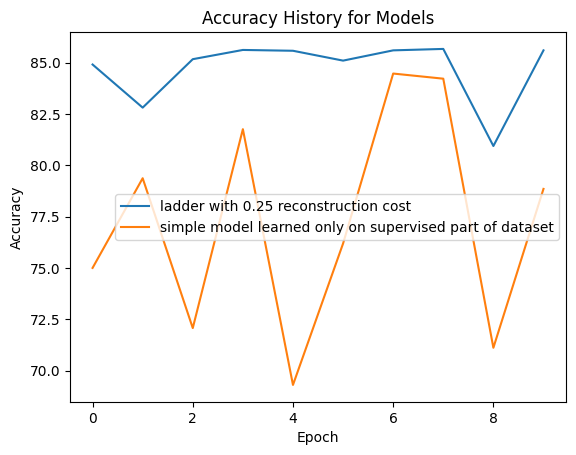

<Figure size 1700x1000 with 0 Axes>

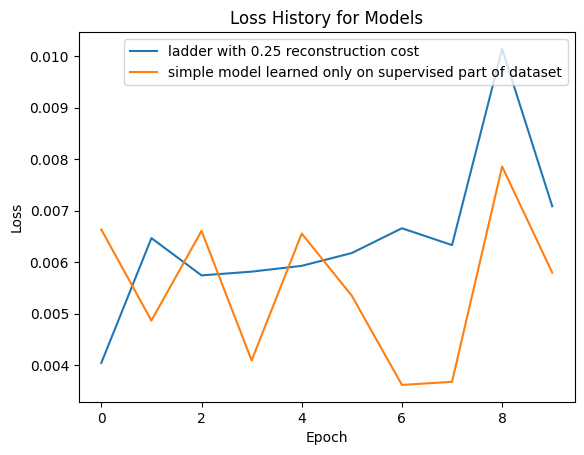

<Figure size 1700x1000 with 0 Axes>

In [12]:
plot_accuracy_history(accuracy_plots)
plot_loss_history(loss_plots)

## Модель з більшою вагою reconstruction cost

### RC rate = 0.5

In [13]:
# Define the model
model = LadderNet(input_shape=(1, 28, 28), num_classes=10, rc_rate=0.5)

# Move the model to the device
model.to(device)

# Define the loss functions
labeled_loss_fn = model.labeled_loss
reconstruction_loss_fn = model.reconstruction_loss

num_epochs = 10

# Define the optimizer
optimizer = optim.Adam(model.parameters())

accuracy_plot = []
loss_plot = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    for data_labeled, target_labeled, data_unlabeled in tqdm(dataloader):
        # Train the model on the labeled data
        data_labeled = data_labeled.to(device)
        target_labeled = target_labeled.to(device)
        data_unlabeled = data_unlabeled.to(device)

        optimizer.zero_grad()
        output, x_reconstructed, out1, dout1, out2, dout2, out3, dout3 = model(data_labeled, None)
        loss_labeled = labeled_loss_fn(output, target_labeled) + reconstruction_loss_fn(data_labeled, x_reconstructed,
                                                                                        out1, dout1, out2, dout2, out3,
                                                                                        dout3)
        loss_labeled.backward()
        optimizer.step()

        # Train the model on the unlabeled data
        _, x_reconstructed, out1, dout1, out2, dout2, out3, dout3 = model(None, data_unlabeled)
        x_reconstructed = x_reconstructed.view(-1, 784)
        data_unlabeled = data_unlabeled.view(-1, 784)
        loss_unlabeled = reconstruction_loss_fn(data_unlabeled, x_reconstructed, out1, dout1, out2, dout2, out3, dout3)
        loss_unlabeled.backward()
        optimizer.step()

    # Test the model
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output, _, _, _, _, _, _, _ = model(data, None)
            test_loss += labeled_loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    loss_plot.append(test_loss)
    accuracy_plot.append(accuracy)
    print('Epoch: {} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch, test_loss, correct,
                                                                                       len(test_loader.dataset),
                                                                                       accuracy))

100%|██████████| 446/446 [00:25<00:00, 17.30it/s]


Epoch: 0 Test set: Average loss: 0.0042, Accuracy: 8382/10000 (84%)


100%|██████████| 446/446 [00:26<00:00, 16.91it/s]


Epoch: 1 Test set: Average loss: 0.0056, Accuracy: 8469/10000 (85%)


100%|██████████| 446/446 [00:26<00:00, 17.15it/s]


Epoch: 2 Test set: Average loss: 0.0067, Accuracy: 8209/10000 (82%)


100%|██████████| 446/446 [00:26<00:00, 16.98it/s]


Epoch: 3 Test set: Average loss: 0.0057, Accuracy: 8596/10000 (86%)


100%|██████████| 446/446 [00:26<00:00, 17.02it/s]


Epoch: 4 Test set: Average loss: 0.0056, Accuracy: 8591/10000 (86%)


100%|██████████| 446/446 [00:26<00:00, 16.99it/s]


Epoch: 5 Test set: Average loss: 0.0068, Accuracy: 8399/10000 (84%)


100%|██████████| 446/446 [00:25<00:00, 17.16it/s]


Epoch: 6 Test set: Average loss: 0.0061, Accuracy: 8587/10000 (86%)


100%|██████████| 446/446 [00:26<00:00, 17.05it/s]


Epoch: 7 Test set: Average loss: 0.0064, Accuracy: 8560/10000 (86%)


100%|██████████| 446/446 [00:25<00:00, 17.31it/s]


Epoch: 8 Test set: Average loss: 0.0064, Accuracy: 8588/10000 (86%)


100%|██████████| 446/446 [00:25<00:00, 17.19it/s]


Epoch: 9 Test set: Average loss: 0.0071, Accuracy: 8569/10000 (86%)


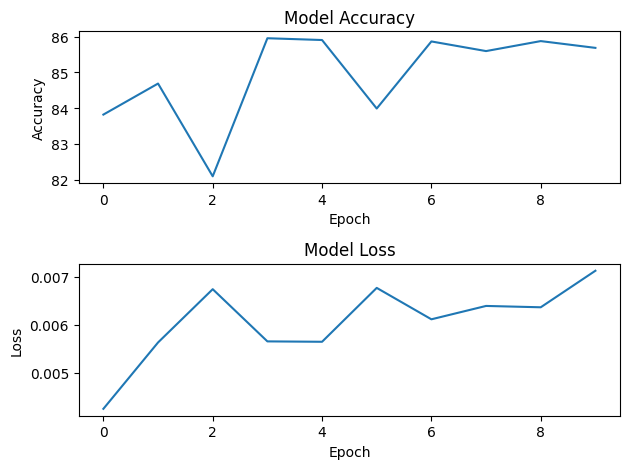

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1000
           1       0.99      0.96      0.97      1000
           2       0.77      0.78      0.78      1000
           3       0.85      0.87      0.86      1000
           4       0.75      0.78      0.77      1000
           5       0.97      0.95      0.96      1000
           6       0.64      0.59      0.61      1000
           7       0.93      0.95      0.94      1000
           8       0.97      0.96      0.96      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [14]:
plot_history(loss_plot, accuracy_plot, loss_plots, accuracy_plots, 'ladder with 0.5 reconstruction cost')
evaluate_model(model, test_loader)

### RC rate = 1

In [15]:
# Define the model
model = LadderNet(input_shape=(1, 28, 28), num_classes=10, rc_rate=1)

# Move the model to the device
model.to(device)

# Define the loss functions
labeled_loss_fn = model.labeled_loss
reconstruction_loss_fn = model.reconstruction_loss

num_epochs = 10

# Define the optimizer
optimizer = optim.Adam(model.parameters())

accuracy_plot = []
loss_plot = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    for data_labeled, target_labeled, data_unlabeled in tqdm(dataloader):
        # Train the model on the labeled data
        data_labeled = data_labeled.to(device)
        target_labeled = target_labeled.to(device)
        data_unlabeled = data_unlabeled.to(device)

        optimizer.zero_grad()
        output, x_reconstructed, out1, dout1, out2, dout2, out3, dout3 = model(data_labeled, None)
        loss_labeled = labeled_loss_fn(output, target_labeled) + reconstruction_loss_fn(data_labeled, x_reconstructed,
                                                                                        out1, dout1, out2, dout2, out3,
                                                                                        dout3)
        loss_labeled.backward()
        optimizer.step()

        # Train the model on the unlabeled data
        _, x_reconstructed, out1, dout1, out2, dout2, out3, dout3 = model(None, data_unlabeled)
        x_reconstructed = x_reconstructed.view(-1, 784)
        data_unlabeled = data_unlabeled.view(-1, 784)
        loss_unlabeled = reconstruction_loss_fn(data_unlabeled, x_reconstructed, out1, dout1, out2, dout2, out3, dout3)
        loss_unlabeled.backward()
        optimizer.step()

    # Test the model
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output, _, _, _, _, _, _, _ = model(data, None)
            test_loss += labeled_loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    loss_plot.append(test_loss)
    accuracy_plot.append(accuracy)
    print('Epoch: {} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch, test_loss, correct,
                                                                                       len(test_loader.dataset),
                                                                                       accuracy))

100%|██████████| 446/446 [00:26<00:00, 17.09it/s]


Epoch: 0 Test set: Average loss: 0.0044, Accuracy: 8290/10000 (83%)


100%|██████████| 446/446 [00:26<00:00, 17.14it/s]


Epoch: 1 Test set: Average loss: 0.0052, Accuracy: 8505/10000 (85%)


100%|██████████| 446/446 [00:26<00:00, 16.97it/s]


Epoch: 2 Test set: Average loss: 0.0049, Accuracy: 8561/10000 (86%)


100%|██████████| 446/446 [00:26<00:00, 17.12it/s]


Epoch: 3 Test set: Average loss: 0.0062, Accuracy: 8416/10000 (84%)


100%|██████████| 446/446 [00:26<00:00, 17.00it/s]


Epoch: 4 Test set: Average loss: 0.0077, Accuracy: 8163/10000 (82%)


100%|██████████| 446/446 [00:26<00:00, 17.12it/s]


Epoch: 5 Test set: Average loss: 0.0062, Accuracy: 8488/10000 (85%)


100%|██████████| 446/446 [00:25<00:00, 17.20it/s]


Epoch: 6 Test set: Average loss: 0.0081, Accuracy: 8382/10000 (84%)


100%|██████████| 446/446 [00:25<00:00, 17.27it/s]


Epoch: 7 Test set: Average loss: 0.0066, Accuracy: 8565/10000 (86%)


100%|██████████| 446/446 [00:25<00:00, 17.30it/s]


Epoch: 8 Test set: Average loss: 0.0058, Accuracy: 8561/10000 (86%)


100%|██████████| 446/446 [00:26<00:00, 17.03it/s]


Epoch: 9 Test set: Average loss: 0.0070, Accuracy: 8568/10000 (86%)


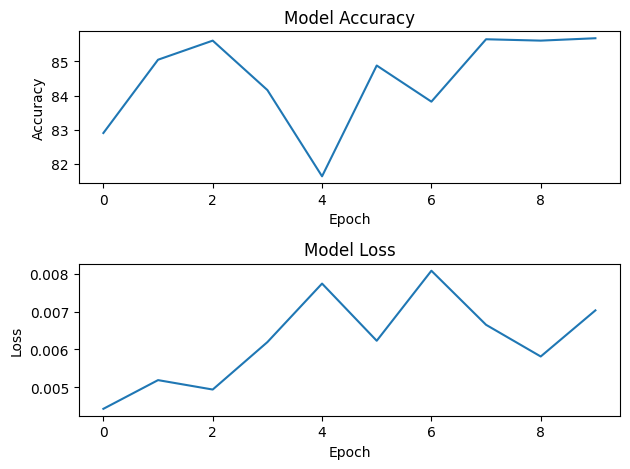

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1000
           1       0.99      0.95      0.97      1000
           2       0.78      0.77      0.78      1000
           3       0.89      0.83      0.86      1000
           4       0.79      0.79      0.79      1000
           5       0.96      0.97      0.97      1000
           6       0.59      0.65      0.62      1000
           7       0.93      0.95      0.94      1000
           8       0.97      0.93      0.95      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [16]:
plot_history(loss_plot, accuracy_plot, loss_plots, accuracy_plots, 'ladder with 1 reconstruction cost')
evaluate_model(model, test_loader)

### Порівняння моделей

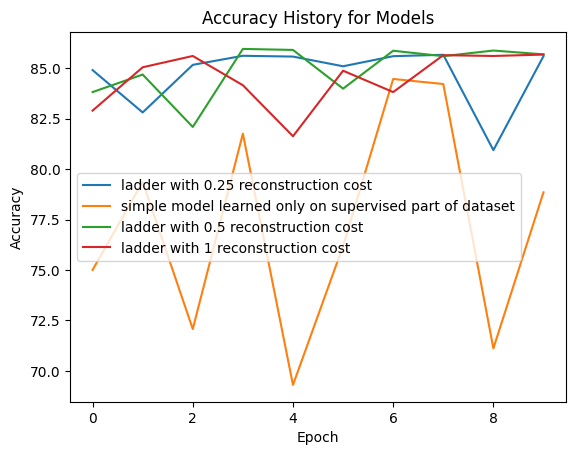

<Figure size 1700x1000 with 0 Axes>

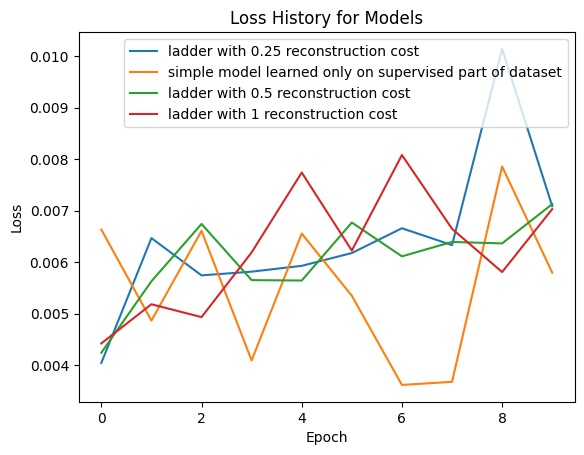

<Figure size 1700x1000 with 0 Axes>

In [17]:
plot_accuracy_history(accuracy_plots)
plot_loss_history(loss_plots)